**Assignment 1: Image formation**

*CPSC 480/580: Computer Vision*

*Yale University*

*Instructor: Alex Wong*

**Prerequisites**:

1. Assuming you have set up a directory structure of
```
/content/drive/MyDrive/Colab Notebooks/CPSC 480-580: Computer Vision/Assignments
```

2. Prior to starting this assignment, please create a directory called 'data' within your 'Assignments' directory and within 'data' create a directory called '01_assignment', i.e.
```
/content/drive/MyDrive/Colab Notebooks/CPSC 480-580: Computer Vision/Assignments/data/01_assignment
```

3. Download the following files and upload them to assignment_01 directory:
```
RGB intensities: https://drive.google.com/file/d/1-By3ngwjHpebkFb8aZMsIb5PSN32qS2H/view?usp=drive_link
3D point cloud: https://drive.google.com/file/d/1-0JIiKZ1I19aptB-HzPQUrrb5tEAgQxf/view?usp=drive_link
Camera intrinsics: https://drive.google.com/file/d/1-RlrXMXyKrpYEPflnpV-TiTltKXpVYxH/view?usp=drive_link
```

In this assignment, we will implement perspective projection and create an image from a point cloud (3-dimensional points in space) with associated RGB intensities and the camera intrinsic calibration matrix.


**Submission**:

1. Implement all TODOs in the code blocks below.

2. Run the Colab Notebook to produce results for each code block.

3. List any collaborators.

```
Collaborators: Doe, Jane (Please write names in <Last Name, First Name> format)

Collaboration details: Discussed ... implementation details with Jane Doe.
```

Mount Google Drive onto Google Colab

In [31]:
from google.colab import drive
from google.colab import auth
from google.auth import default
import os

drive.mount('/content/drive/', force_remount=True)
os.chdir('/content/drive/MyDrive/Colab Notebooks/CPSC 480-580: Computer Vision/Assignments')

Mounted at /content/drive/


Import packages

In [32]:
import os, cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from PIL import Image

Global constants

In [33]:
# Shape of target image, necessary for projection
SHAPE_IMAGE = [375, 1242, 3]

# Colormap for visualizing depth
DEPTH_COLORMAP = cm.get_cmap(name='jet')
DEPTH_COLORMAP.set_under(color='black')

/tmp/ipython-input-3273606559.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  DEPTH_COLORMAP = cm.get_cmap(name='jet')


Utility functions for plotting

In [34]:
def config_plot(ax):
    '''
    Function to remove axis tickers, labels, and frame from a specific axes

    Arg(s):
        ax : matplotlib.axes.Axes
            The axes object to configure.
    '''
    # Remove the frame around the plot
    ax.set_frame_on(False)
    # Turn off the axis lines and labels
    ax.set_axis_off()

In [35]:
def plot_rgb_to_image(rgb_values, xy_coordinates, image):
    '''
    Plots RGB values onto the image plane

    TODO: Plots RGB values onto the image plane only if they are within its bounds

    Arg(s):
        rgb_values : numpy[float32]
            3 x N RGB values (channels x number of points)
        xy_coordinates : numpy[float32]
            2 x N coordinates corresponding to target image to be plotted (u, v coordinates for each point)
        image : numpy[float32]
            h x w x 3 image to be populated (height x width x channels)
    Returns:
        numpy[float32] : RGB image
    '''
    # Get the dimensions of the target image
    height, width, _ = image.shape
    n_points = xy_coordinates.shape[1]

    for i in range(n_points):
      # Extract the u (horizontal) and v (vertical) coordinates from the projected points
      # xy_coordinates has shape (2, N), where the first row is u and the second row is v
      u = np.round(xy_coordinates[0, i]).astype(int) # image indices must be integers
      v = np.round(xy_coordinates[1, i]).astype(int) # why does not rounding leading to noise?

      # A point is in bounds if its u coordinate is between 0 (inclusive) and width (exclusive)
      # AND its v coordinate is between 0 (inclusive) and height (exclusive).
      if (u >= 0 and u < width) and (v >= 0 and v < height):
        rgb = rgb_values[:, i]
        image[v, u] = rgb


    # Select the RGB values for the in-bounds points.
    # rgb_values has shape (3, N), so we select all channels (:) for the columns
    # where the corresponding point is in bounds.


    # Assign the RGB values to the corresponding pixel locations in the image.
    # The image array is indexed by [row, column], which corresponds to [v, u].
    # We use the in-bounds v and u coordinates as indices.
    # rgb_in_bounds has shape (3, num_in_bounds_points), while the image expects
    # the color channels to be the last dimension.
    # We transpose rgb_in_bounds (.T) to get shape (num_in_bounds_points, 3)
    # so it matches the shape of the slice of the image we are assigning to.


    return image

In [36]:
def plot_depth_to_image(depth_values, xy_coordinates, image):
    '''
    Plots depth values onto the image plane

    TODO: Plots depth values larger than 0 onto the image plane, and
    if the points are within the image plane bounds

    Arg(s):
        depth_values : numpy[float32]
            N depth values (Z-coordinates)
        xy_coordinates : numpy[float32]
            2 x N coordinates corresponding to target image to be plotted (u, v coordinates for each point)
        image : numpy[float32]
            h x w image to be populated with depth values (height x width)
    Returns:
        numpy[float32] : depth map
    '''
    height, width = image.shape
    n_points = xy_coordinates.shape[1]

    depth_map = np.zeros((height, width), dtype=np.float32)

    # interate through the pixel coordinates and plot depth
    for i in range(n_points):
      u = int(round(xy_coordinates[0, i])) # x coords => cols
      v = int(round(xy_coordinates[1, i])) # y coords => rows
      depth = depth_values[i]
      if 0 <= u < width and 0 <= v < height and np.isscalar(depth) and depth > 0:
        # v, u since horizontal, vertical
        depth_map[v, u] = depth

    return depth_map

Helper function for perspective projection

In [37]:
def perspective_projection(xyz_h, K, full_rank=False):
    '''
    Performs perspective project with intrinsic calibration matrix K

    TODO: Project a homogeneous point cloud onto the image plane
    If full_rank is true, then augment the intrinsic calibration matrix

    Arg(s):
        xyz_h : numpy[float32]
            N xyz points in homogeneous form
        K : numpy[float32]
            intrinsic calibration matrix
        full_rank : bool
            if true, perform the projection using full rank matrices
    Returns:
        numpy[float32] : image coordinates
    '''
    if full_rank:
      # augment K to a 3x4 matrix by adding a column of zeros
      K_aug = np.hstack([K, np.zeros((3, 1))])
      proj_h = np.dot(K_aug, xyz_h)
    else:
      # assuming xyz_h is already in camera coordinates and has shape (3, N)
      proj_h = np.dot(K, xyz_h)

    # Convert homogeneous image coordinates to inhomogeneous image coordinates (u, v)
    # Divide by the third row (w) to normalize
    w = proj_h[2:3, :]
    proj_ih = proj_h[:2, :] / w # divide by w

    # result is the inhomogeneous image coordinates (u, v)
    uv = proj_ih

    return uv


Load RGB, XYZ and intrinsics data

In [38]:
# TODO: Load RGB values from numpy array as unsigned 8 bit integer
rgb = np.load('data/01_assignment/rgb_00001.npy')

# TODO: Load XYZ coordinates (point cloud) from numpy array
xyz = np.load('data/01_assignment/xyz_00001.npy')

# Print shape of RGB and XYZ arrays
print('Shape of RGB values: {}'.format(rgb.shape))
print('Shape of XYZ coordinates: {}'.format(xyz.shape))

# TODO: Load intrinsics text file as numpy array
intrinsics = np.loadtxt('data/01_assignment/intrinsics.txt')

# Print the shape of intrinsic calibration parameters and its values
print('Shape of intrinsic calibration parameters: {}'.format(intrinsics.shape))
print('K: \n{}'.format(intrinsics))

# TODO: Create the intrinsics matrix
fx, fy, cx, cy = intrinsics
K = np.array([[fx, 0, cx],
              [0, fy, cy],
              [0, 0, 1]])

# Print the shape of the intrinsics matrix and its values
print('Shape of intrinsics: {}'.format(K.shape))
print('K: \n{}'.format(K))

Shape of RGB values: (3, 465750)
Shape of XYZ coordinates: (3, 465750)
Shape of intrinsic calibration parameters: (4,)
K: 
[725.0087 725.0087 620.5    187.    ]
Shape of intrinsics: (3, 3)
K: 
[[725.0087   0.     620.5   ]
 [  0.     725.0087 187.    ]
 [  0.       0.       1.    ]]


Project XYZ onto the image plane

In [39]:
# Get number of points in point cloud
n_point = xyz.shape[-1]

# TODO: Convert XYZ to homogenous form
xyz_h = np.vstack((xyz, np.ones((1, n_point))))

print('Shape of homogeneous XYZ: {}'.format(xyz_h.shape))

# TODO: Perform perspective projection to get inhomogeneous image coordinates for plotting
# The perspective_projection function now returns inhomogeneous coordinates (u, v) of shape (2, N)
xy = perspective_projection(xyz_h, K, True)

# Print shape of image coordinates
print('Shape of image coordinates: {}'.format(xy.shape))

Shape of homogeneous XYZ: (4, 465750)
Shape of image coordinates: (2, 465750)


Create image from image coordinates and RGB values

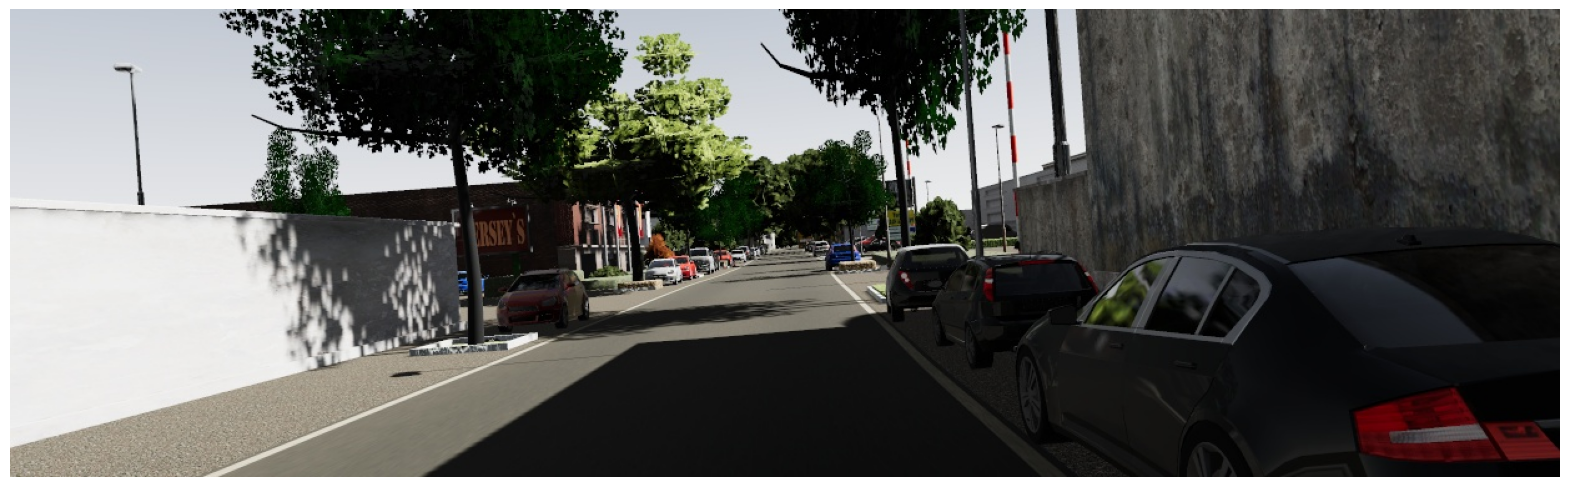

In [40]:
# TODO: Define array of zeros with image shape
image = np.zeros((SHAPE_IMAGE), dtype=np.uint8)

# TODO: Plot RGB values onto the image plane
image = plot_rgb_to_image(rgb, xy, image)

# TODO: Plot image with figure size of 20 by 20
# Note: be sure to remove axis tickers
fig, ax = plt.subplots(figsize=(20, 20))
config_plot(ax)
ax.imshow(image) # Use plt.imshow() to display the image
plt.show() # Use plt.show() to display the plot

Project onto the image plane with full rank intrinsics matrix

In [41]:
print('Min and max values of depth map: {}'.format((np.min(xyz_h[2]), np.max(xyz_h[2]))))

# TODO: Perform perspective projection with full rank intrinsic calibration matrix
points_image_h = perspective_projection(xyz_h, K, True)

# Print shape of points in image coordinates
print('Shape of points in image coordinates: {}'.format(points_image_h.shape))

'''
To create a depth map, you need to associate the original depth values
from the 3D points (xyz) with their projected 2D locations (xy).
'''
# TODO: Extract the depth values (Z-coordinates) from the original xyz_h array.
depth_values = xyz_h[2, :]

Min and max values of depth map: (np.float64(2.9), np.float64(655.35))
Shape of points in image coordinates: (2, 465750)


Create a depth map from image coordinates and depth values

Shape of depth map: (375, 1242)
Min and max values of depth map: (np.float32(2.9), np.float32(655.35))


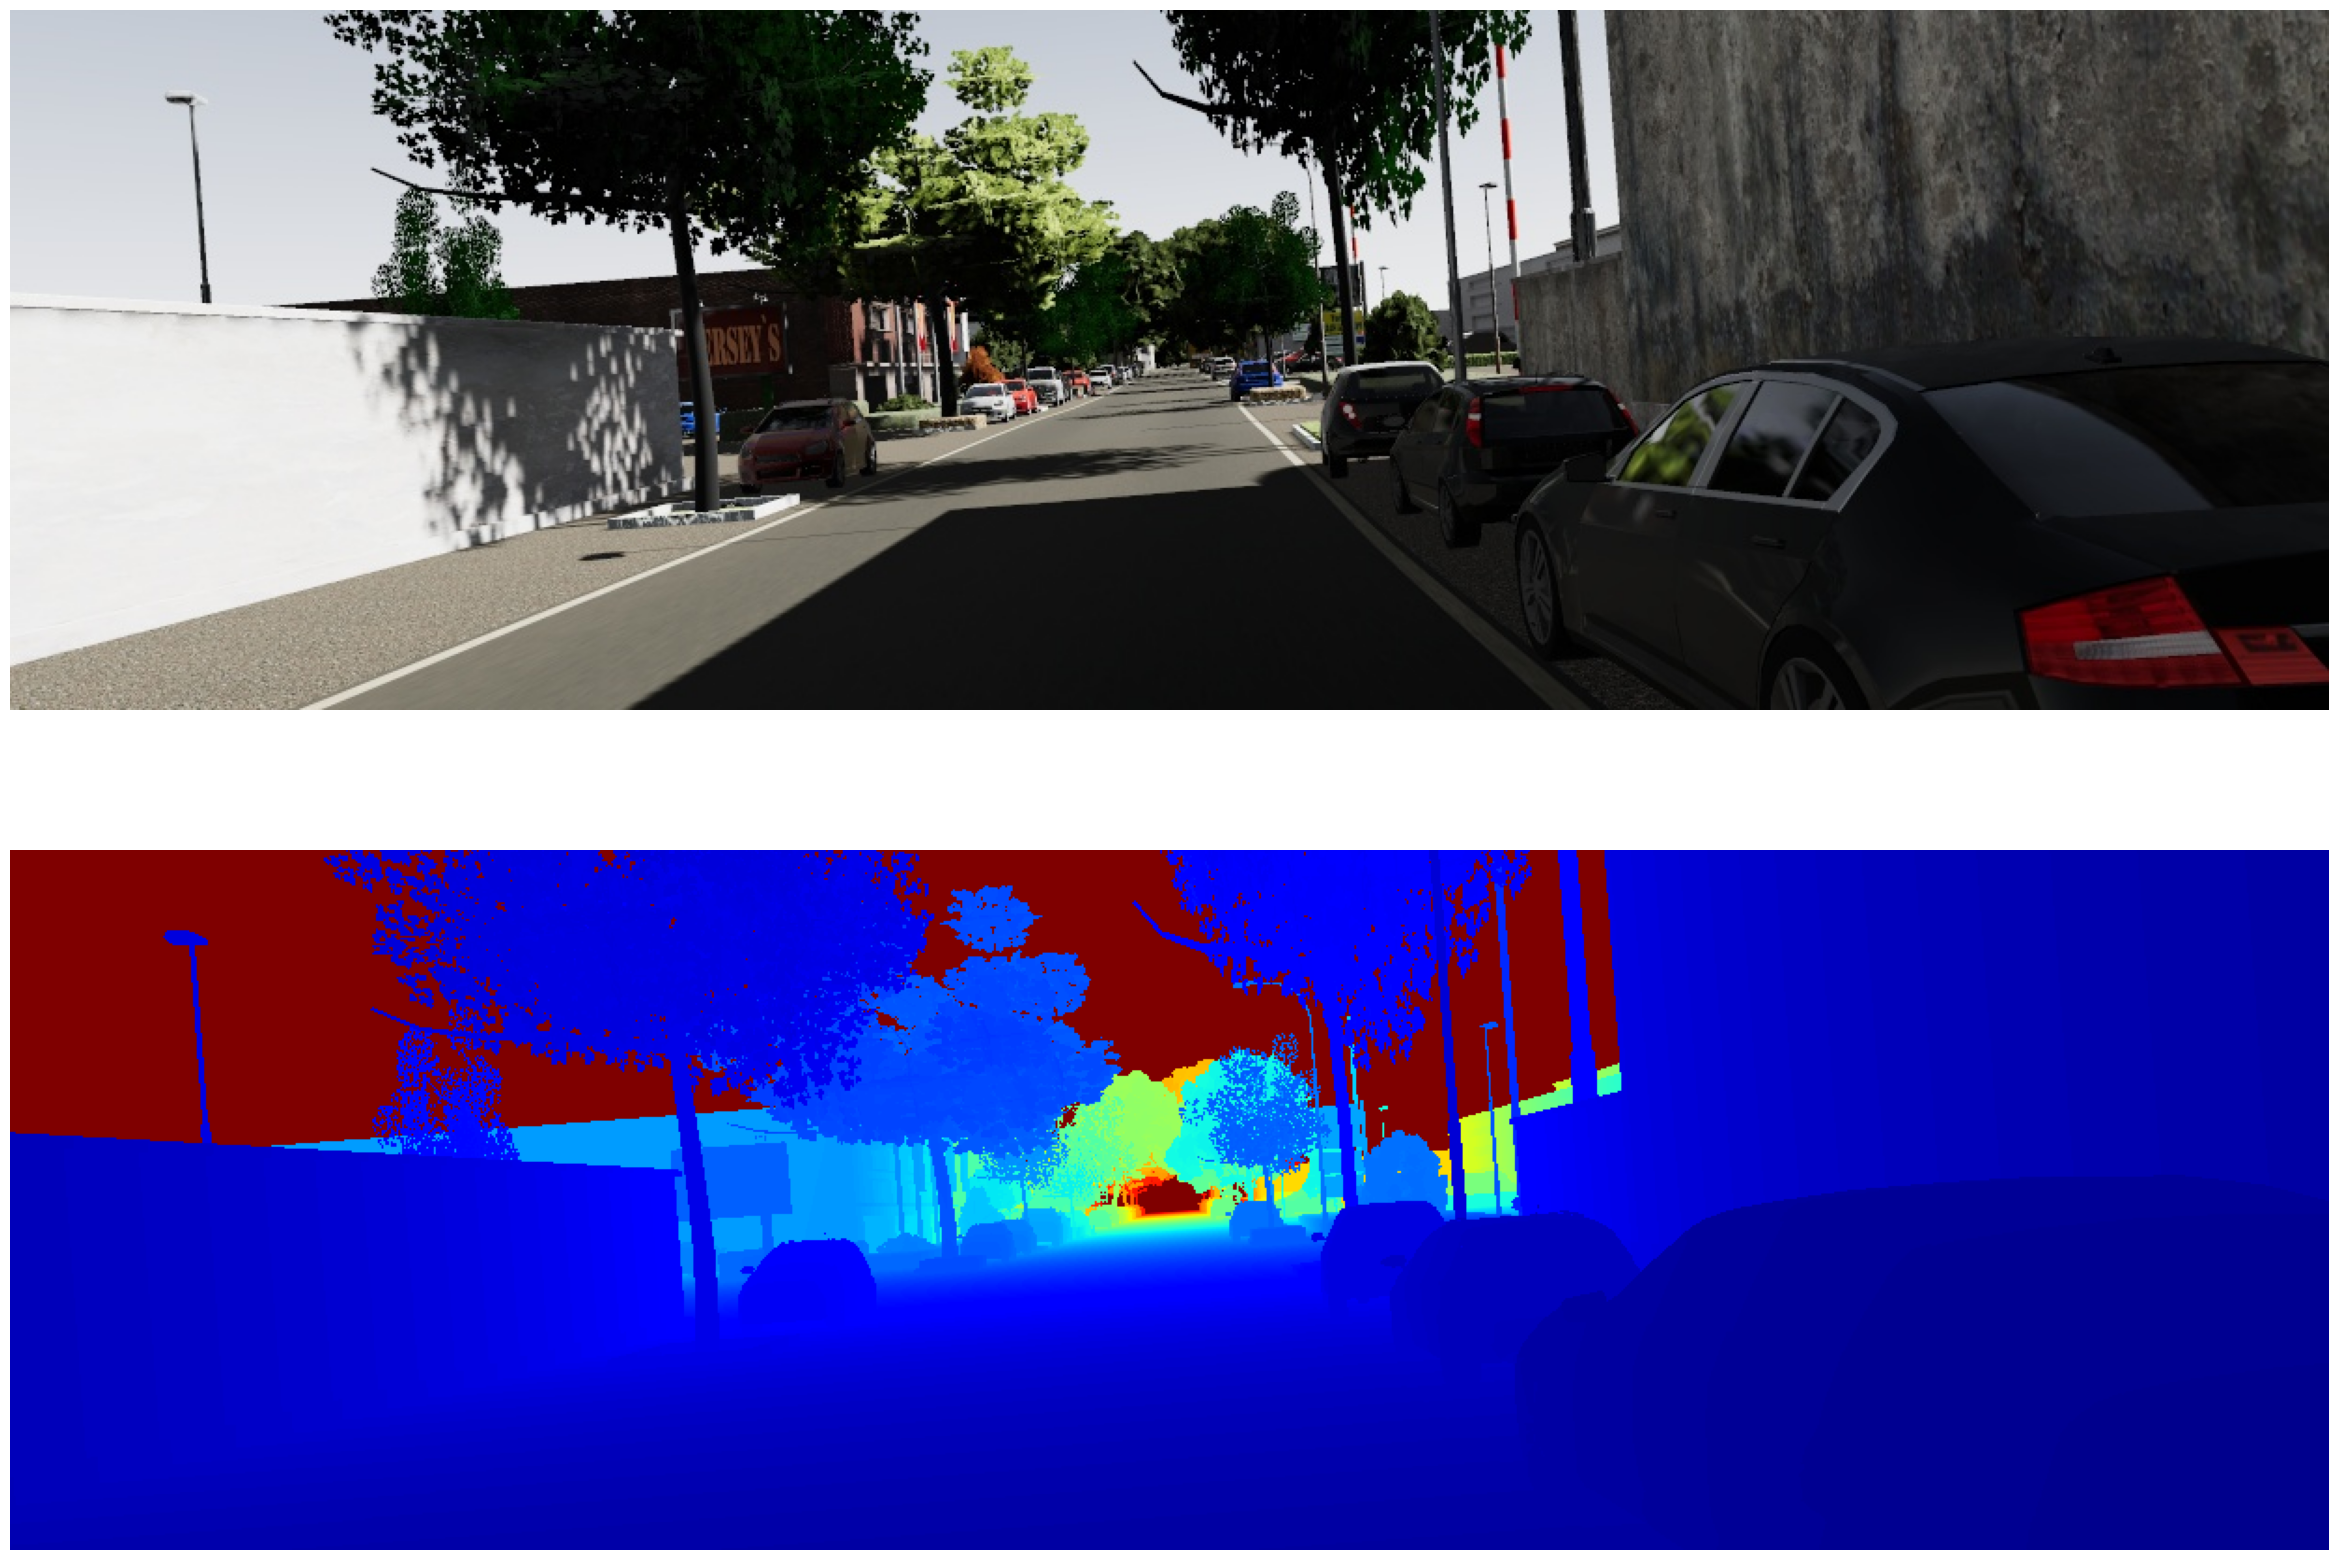

In [42]:
# TODO: Create an empty image to be used to store depth values (depth map)
# Create a 2D array for the depth map with the same height and width as the image,
# using a floating-point data type to store depth values.
depth_map = np.zeros((SHAPE_IMAGE[0], SHAPE_IMAGE[1]), dtype=np.float32)

# TODO: Plot depth values onto the image plane as a depth map
depth_map = plot_depth_to_image(depth_values, xy, depth_map)

# Print shape of depth map
print('Shape of depth map: {}'.format(depth_map.shape))
print('Min and max values of depth map: {}'.format((np.min(depth_map), np.max(depth_map))))

# TODO: Plot a 2 by 1 figure with figure size of 30 by 20 for the image and
# the depth map using depth colormap defined as global constant and vmin=1e-3 and vmax=200
# Note: be sure to remove axis tickers
fig, (plt1, plt2) = plt.subplots(2, 1, figsize=(30, 20))

# RGB image
plt1.imshow(image)
config_plot(plt1)
# plt1.set_title('RGB Image')

plt2.imshow(depth_map, cmap=DEPTH_COLORMAP, vmin=1e-3, vmax=200)
config_plot(plt2)
# plt2.set_title('Depth Map')

plt.show()

Experiment: Effect of changing focal length

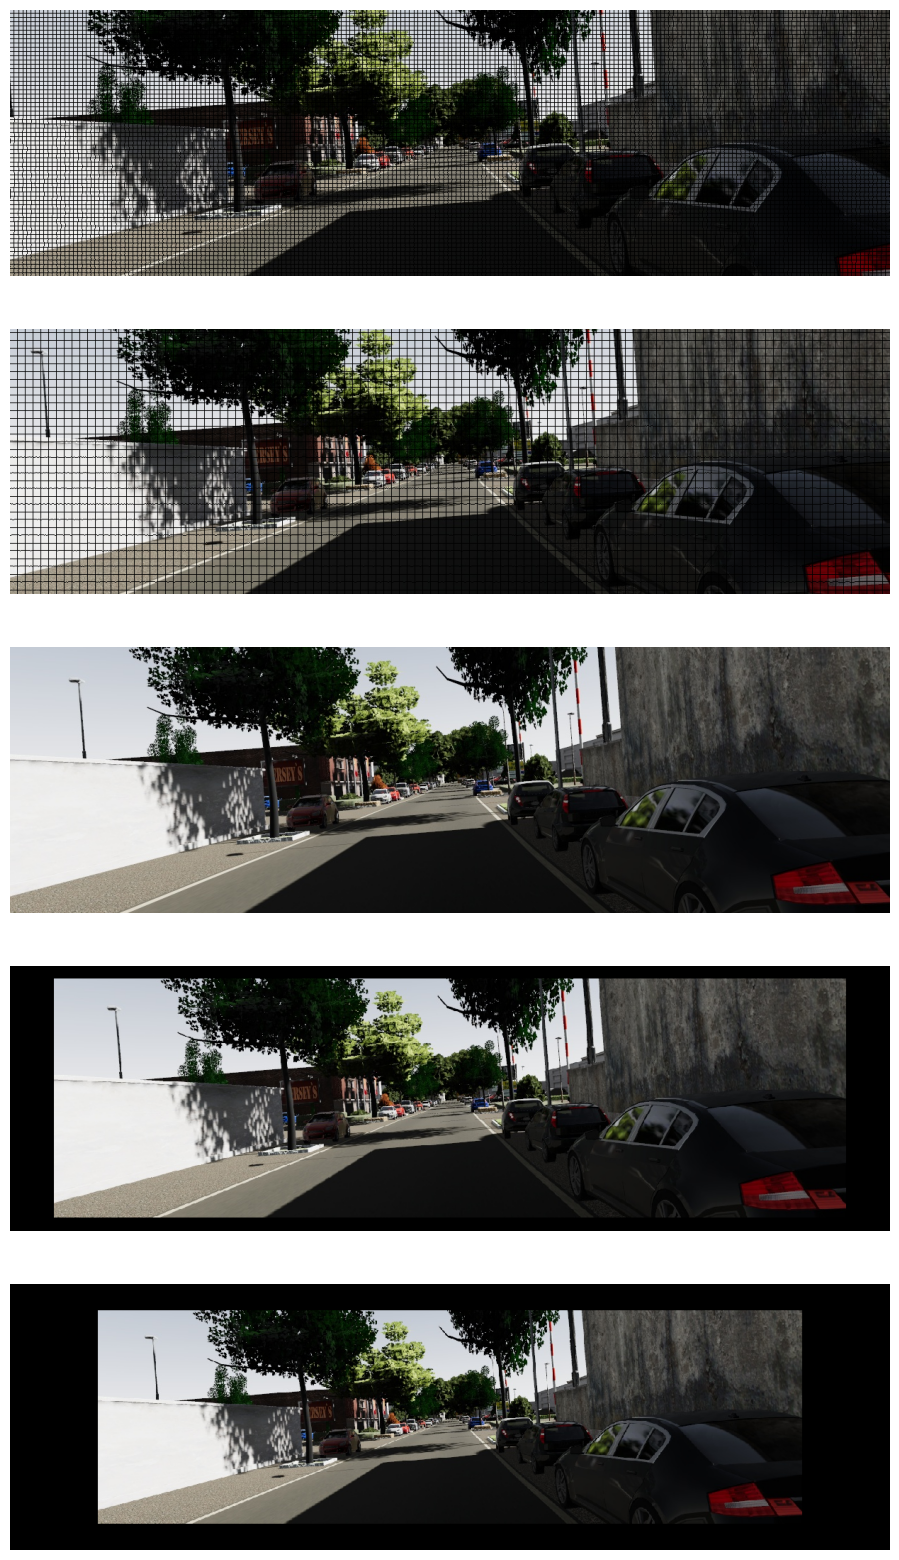

In [43]:
focal_length_scaling_factors = [1.2, 1.1, 1.0, 0.9, 0.8]

fig = plt.figure(figsize=(100, 20))

# TODO: Iterate over focal length scaling factors, apply them multiplicatively to both components,
# perform perspective projection, and create images for a fixed size (SHAPE_IMAGE) image plane
# Hint: You should observe a ``zoom in zoom out effect''
for idx, scale in enumerate(focal_length_scaling_factors):
    # multiply with K
    '''
    fx, fy, cx, cy = intrinsics
    K = np.array([[fx, 0, cx],
                  [0, fy, cy],
                  [0, 0, 1]])
    '''
    K_scaled = np.array([[fx * scale, 0, cx],
                             [0, fy * scale, cy],
                             [0, 0, 1]])

    # perform perspective projection
    xy_scaled = perspective_projection(xyz_h, K_scaled, True)

    # create an image
    scaled_image = np.zeros((SHAPE_IMAGE), dtype=np.uint8)
    scaled_image = plot_rgb_to_image(rgb, xy_scaled, scaled_image)

    # TODO: Create a figure with 5 x 1 subplots and plot each image
    # Note: be sure to remove axis tickers
    # ax = fig.add_subplot(1, len(focal_length_scaling_factors), idx + 1)
    ax = fig.add_subplot(5, 1, idx + 1)
    ax.imshow(scaled_image)
    config_plot(ax)

plt.show()

Experiment: Effect of changing principal point offset

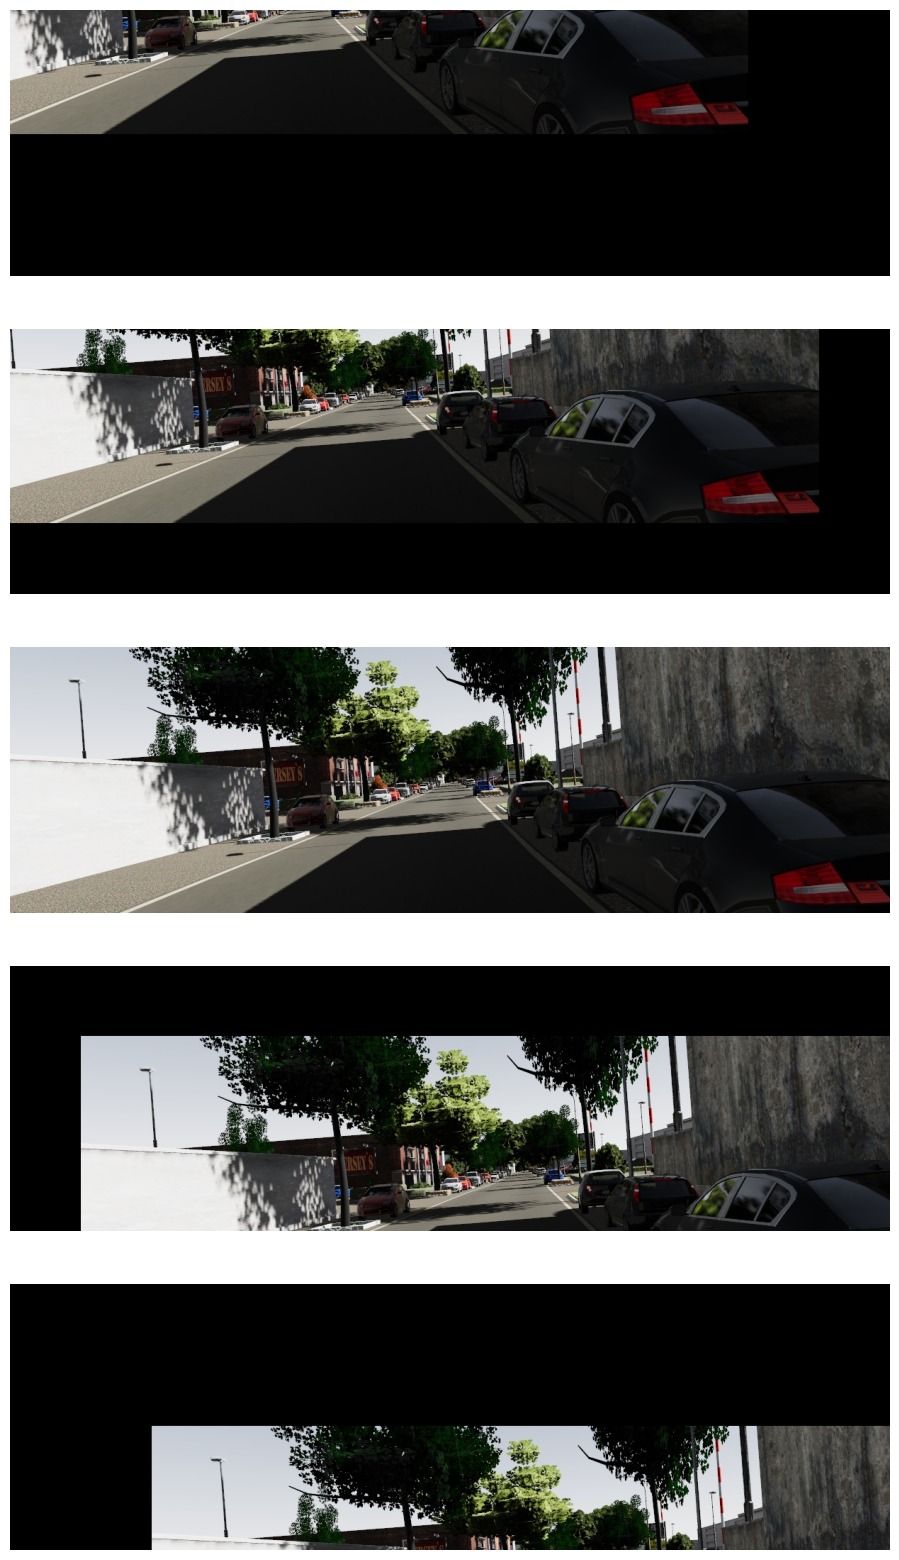

In [44]:
principal_point_offset_shifts = [-200, -100, 0, 100, 200]

fig = plt.figure(figsize=(100, 20))

# TODO: Iterate over principal point offset shifts, apply them additively to both components,
# perform perspective projection, and create images for a fixed size (SHAPE_IMAGE) image plane
# Hint: You should observe the projection to land on different parts of the image
'''
fx, fy, cx, cy = intrinsics
K = np.array([[fx, 0, cx],
              [0, fy, cy],
              [0, 0, 1]])
'''
for idx, shift in enumerate(principal_point_offset_shifts):
    K_offset = np.array([[fx, 0, cx + shift],
                         [0 , fy, cy + shift],
                         [0, 0, 1]
                         ])
    xy_shift = perspective_projection(xyz_h, K_offset, True)
    shift_image = np.zeros((SHAPE_IMAGE), dtype=np.uint8)
    shift_image = plot_rgb_to_image(rgb, xy_shift, shift_image)

    # TODO: Create a figure with 5 x 1 subplots and plot each image
    # Note: be sure to remove axis tickers
    ax = fig.add_subplot(5, 1, idx + 1) # 1-based indexing
    ax.imshow(shift_image)
    config_plot(ax)

plt.show()


Experiment: Simulate ``image resizing'' from intrinsics

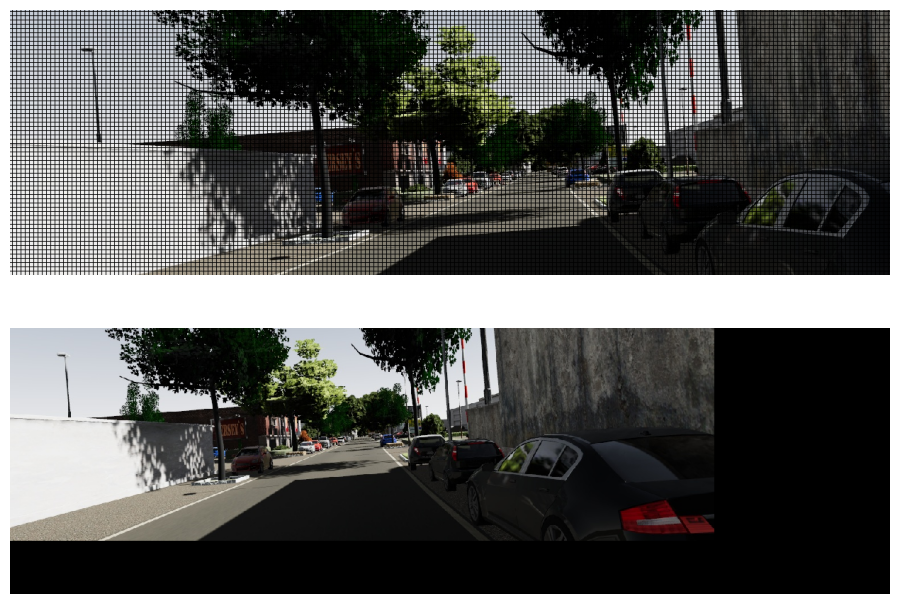

In [45]:
# Suppose that we would like to utilize the intrinsics in ``resizing a photo''
# Now that you have seen the effect of changes in focal length and principal point offsets
# How would you perform an image resize?

resize_factors = [1.2, 0.8]

fig = plt.figure(figsize=(40, 20))

# TODO: Modify the intrinsic calibration parameters to enable resizing of the image
# perform perspective projection, and create images for a fixed size (SHAPE_IMAGE) image plane
# so that you can see the cut off in the imaging growing larger and the empty regions when it shrinks smaller
# Hint: The original of the image plane is at the top left hand corner
for idx, resize_factor in enumerate(resize_factors):
    # generate the new K
    K_resize = np.array([[fx * resize_factor, 0, cx * resize_factor],
                         [0, fy * resize_factor, cy * resize_factor],
                         [0, 0, 1]
                         ])
    xy_resize = perspective_projection(xyz_h, K_resize, True)
    image_resize = np.zeros((SHAPE_IMAGE), dtype=np.uint8)
    image_resize = plot_rgb_to_image(rgb, xy_resize, image_resize)
    # TODO: Create a figure with 2 x 1 subplots and plot each image
    # Note: be sure to remove axis tickers
    ax = fig.add_subplot(5, 1, idx + 1)
    ax.imshow(image_resize)
    config_plot(ax)

plt.show()